In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-11-03_16-52_20200101_20200831_lock_periods_by_2.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.003108003108003108

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

ES       0.25
GC       0.25
NQ       0.25
YM       0.25
total    1.00
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES     1780.60
GC    27821.44
NQ     8277.60
YM    21974.00
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

59853.64000000001

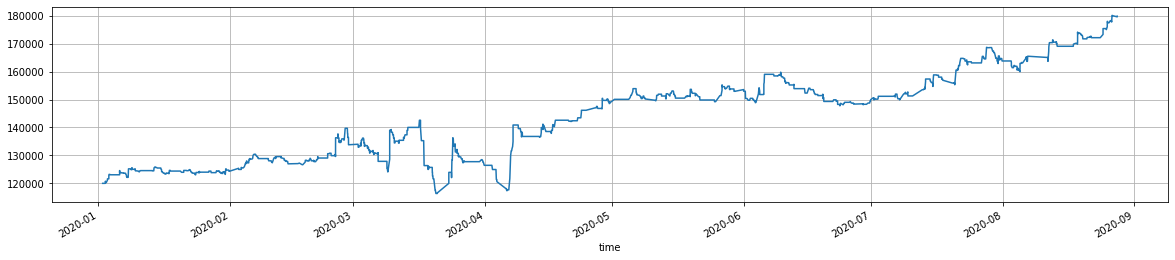

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES    165
 GC    268
 NQ    694
 YM    160
 Name: action, dtype: int64,
 1287)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    0.959302
 GC    1.558140
 NQ    4.034884
 YM    0.930233
 Name: action, dtype: float64,
 7.482558139534884)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     346.50
GC     648.56
NQ    1457.40
YM     336.00
Name: commission, dtype: float64

In [16]:
df.commission.sum()

2788.46

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
NQ,0.42,23.85,727.49,-481.23,1.51,26.43,347.0
GC,0.40,207.62,1270.63,-487.93,2.60,215.49,134.0
YM,0.52,274.68,1236.04,-787.88,1.57,264.56,80.0
ES,0.39,21.71,1640.72,-1014.45,1.62,21.07,82.0
total,0.42,93.08,1019.29,-585.96,1.74,88.24,643.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

contract,ES,GC,NQ,YM,total
contract,,,,,
ES,1.000000,0.116648,0.267208,0.573922,0.784365
GC,0.116648,1.000000,-0.157787,0.056378,0.488045
NQ,0.267208,-0.157787,1.000000,0.081087,0.505187
YM,0.573922,0.056378,0.081087,1.000000,0.627322
total,0.784365,0.488045,0.505187,0.627322,1.000000


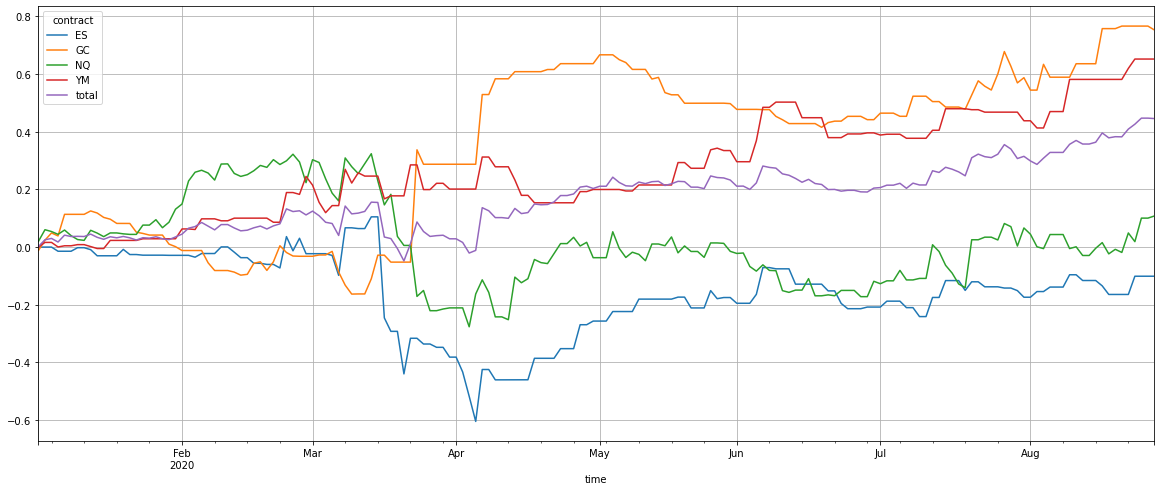

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

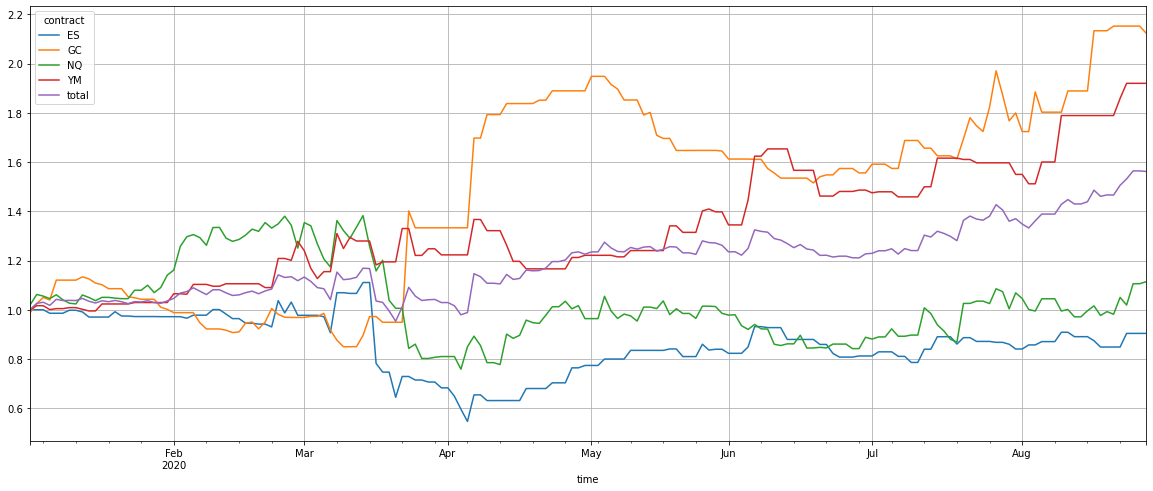

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,-0.137635,2.013871,0.171359,1.600295,0.921544
Cumulative returns,-0.096129,1.123350,0.113996,0.919859,0.561718
Annual volatility,0.673022,0.778597,0.708692,0.491141,0.398285
Sharpe ratio,0.129208,1.745089,0.570424,2.185013,1.834796
Calmar ratio,-0.270832,8.038122,0.379669,10.905742,4.998996
Stability,0.064069,0.665992,0.182460,0.888318,0.842227
Max drawdown,-0.508194,-0.250540,-0.451338,-0.146739,-0.184346
Omega ratio,1.038526,1.857165,1.116908,1.861455,1.485505
Sortino ratio,0.184277,5.946003,0.902735,4.504876,3.469901
Skew,-0.798088,6.296309,0.634804,1.691275,1.656576


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

contract,ES,GC,NQ,YM,total
time,,,,,
2020-01-31,-2.82,0.15,14.05,2.93,3.58
2020-02-29,0.57,-3.28,9.64,24.16,7.94
2020-03-31,-30.15,37.60,-35.23,-4.30,-7.95
2020-04-30,13.32,41.75,19.02,-0.14,19.08
2020-05-31,8.51,-12.94,2.23,14.46,2.97
2020-06-30,-3.25,-5.41,-9.87,6.32,-2.76
2020-07-31,3.47,15.67,20.32,4.29,11.65
2020-08-31,7.56,17.99,4.25,23.88,13.99


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
ES       -10.0
GC       112.0
NQ        11.0
YM        92.0
total     56.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2020-04-07 02:34:00,GC,SELL,1725.00,8205.16
2020-03-24 11:58:30,GC,SELL,1679.70,7985.16
2020-03-09 14:53:00,ES,BUY,2767.00,6345.80
2020-03-24 06:35:30,GC,SELL,1585.10,6305.16
2020-04-07 16:16:30,ES,SELL,2694.25,5920.80
...,...,...,...,...
2020-02-28 21:56:00,ES,BUY,2930.50,-2616.70
2020-03-16 21:01:00,NQ,BUY,7054.25,-2684.20
2020-03-20 07:42:30,ES,BUY,2429.50,-4116.70


In [26]:
daily.sort_values('total', ascending=False)

contract,ES,GC,NQ,YM,total
time,,,,,
2020-04-07,0.197360,0.273505,0.050387,0.117553,0.159701
2020-03-09,0.179303,-0.044495,0.160720,0.134193,0.107430
2020-03-24,0.000000,0.476344,-0.162033,0.000000,0.078578
2020-07-21,0.030277,0.050505,0.180773,-0.003307,0.064562
2020-03-23,0.131527,0.000000,0.000000,0.113360,0.061222
...,...,...,...,...,...
2020-03-19,0.000000,0.000000,-0.135753,0.000000,-0.033938
2020-04-03,-0.080973,0.000000,-0.063447,0.000000,-0.036105
2020-03-06,-0.066807,-0.069140,-0.026613,0.000000,-0.040640
